In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
from PIL import Image


In [3]:
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [4]:

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

SIZE = 256
high_img = []
low_img = []  # Initialize low_img list
path_high_res = '/kaggle/input/img-superres/AnalyticsArena_DataSet/highres/HighResolution_Train'
files_high_res = os.listdir(path_high_res)
files_high_res = sorted_alphanumeric(files_high_res)
for i in tqdm(files_high_res):
    if i == 'Img3500.jpg':
        break
    else:
        img = cv2.imread(path_high_res + '/' + i, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img)



100%|██████████| 3500/3500 [00:56<00:00, 62.18it/s]


In [5]:
path_low_res = '/kaggle/input/img-superres/AnalyticsArena_DataSet/lowres/LowReolution_3x_Train'
files_low_res = os.listdir(path_low_res)
files_low_res = sorted_alphanumeric(files_low_res)
for i in tqdm(files_low_res):
    if i == 'Img_down3500.jpg':
        break
    else:
        img = cv2.imread(path_low_res + '/' + i, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img)

100%|██████████| 3500/3500 [00:38<00:00, 91.68it/s] 


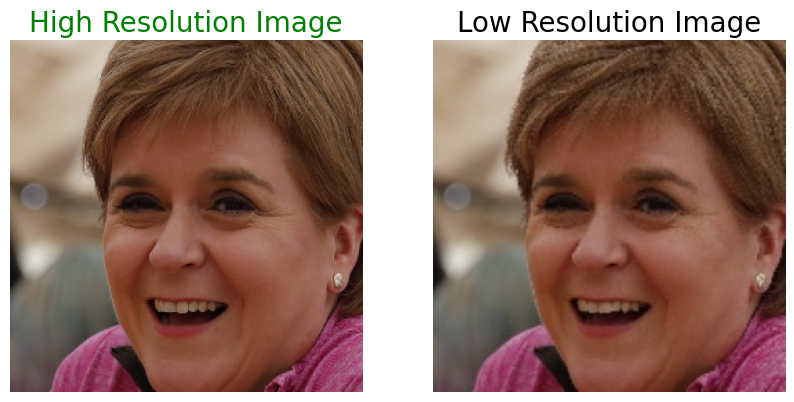

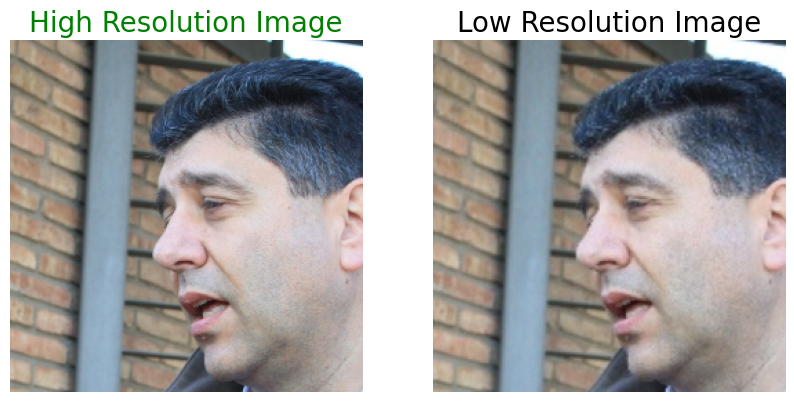

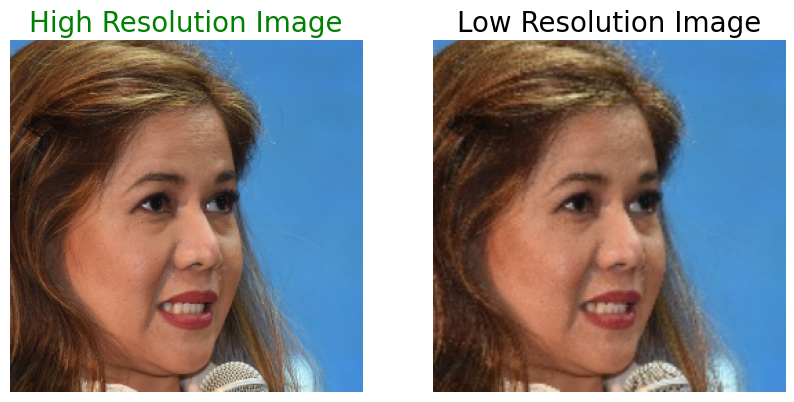

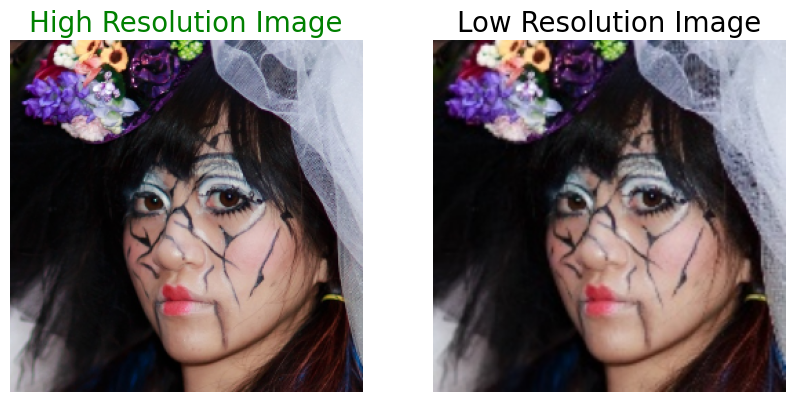

In [6]:
num_samples = 4
random_indices = np.random.choice(len(high_img), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('High Resolution Image', color='green', fontsize=20)
    plt.imshow(high_img[index])
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Low Resolution Image', color='black', fontsize=20)
    plt.imshow(low_img[index])
    plt.axis('off')
    plt.show()

In [7]:
train_high_image = high_img[:2000]
train_low_image = low_img[:2000]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[2000:3000]
validation_low_image = low_img[2000:3000]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[3000:]
test_low_image = low_img[3000:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (2000, 256, 256, 3)
Shape of test images: (500, 256, 256, 3)
Shape of validation images: (1000, 256, 256, 3)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import peak_signal_noise_ratio
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the SRCNN model
def SRCNN(input_shape=(None, None, 3)):
    model = models.Sequential([
        layers.Conv2D(128, (9, 9), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (1, 1), activation='relu', padding='same'),
        layers.Conv2D(3, (5, 5), padding='same')  # Output 3 channels for RGB image
    ])
    return model

# Instantiate the SRCNN model
srcnn_model = SRCNN()

# Compile the model
srcnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Print model summary
srcnn_model.summary()

# Train the model with learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
history = srcnn_model.fit(train_low_image, train_high_image,
                          validation_data=(validation_low_image, validation_high_image),
                          epochs=30, batch_size=16, callbacks=[reduce_lr])

# Generate predicted high-resolution images for test data
predicted_images = srcnn_model.predict(test_low_image)

# Calculate PSNR for each predicted image
psnr_scores = [peak_signal_noise_ratio(test_high_image[i], predicted_images[i]) for i in range(len(test_high_image))]

# Calculate average PSNR across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
print("Average PSNR:", average_psnr)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, None, None,     │        31,232 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 64) │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 32) │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 3)  │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,507 (427.76 KB)

 Trainable params: 109,507 (427.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2024-03-24 19:15:12.806593: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,3,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,256,256]{3,2,1,0}, f32[16,128,256,256]{3,2,1,0}), window={size=9x9 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-24 19:15:13.039394: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.232984451s
Trying algorithm eng0{} for conv (f32[128,3,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,256,256]{3,2,1,0}, f32[16,128,256,256]{3,2,1,0}), window={size=9x9 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-24 19:15:14.961555: E external/

125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 275ms/step - loss: 0.0882 - val_loss: 0.0047 - learning_rate: 1.0000e-04
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - loss: 0.0036 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - loss: 0.0018 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - loss: 0.0014 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - loss: 0.0012 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - loss: 0.0011 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - loss: 0.0011 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - loss: 0.0010 - val_loss: 9.6784e-04 - learning_rate: 1.0000e-04
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - loss: 9.8868e-

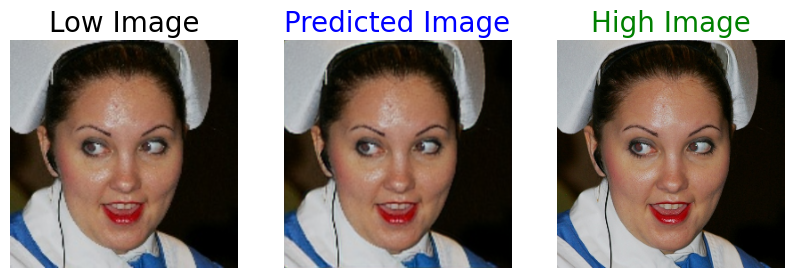

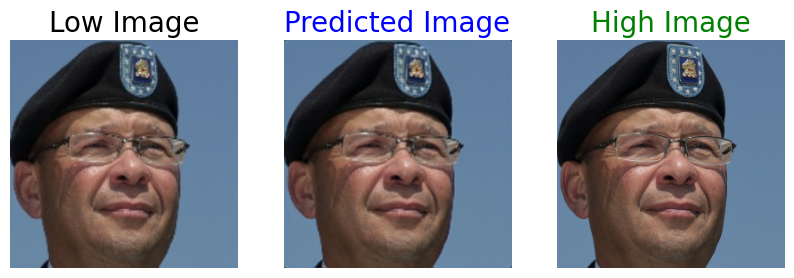

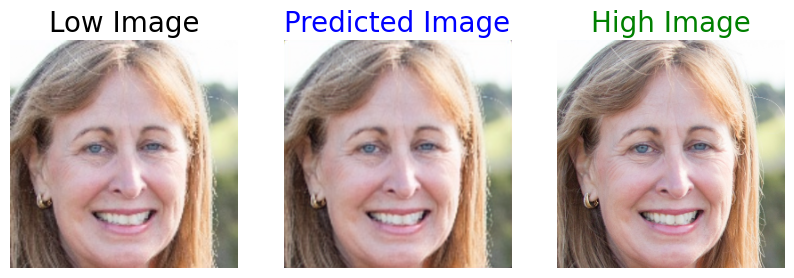

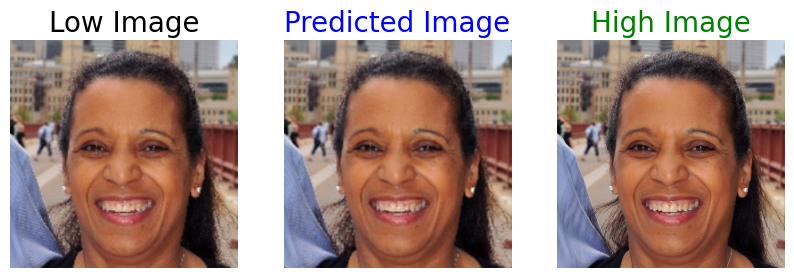

In [9]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import peak_signal_noise_ratio
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ESPCN model
def ESPCN(input_shape=(None, None, 3)):
    model = models.Sequential([
        layers.Conv2D(128, (9, 9), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (1, 1), activation='relu', padding='same'),
        layers.Conv2D(3, (5, 5), padding='same')  # Output 3 channels for RGB image
    ])
    return model

# Instantiate the ESPCN model
espcn_model = ESPCN()

# Compile the model
espcn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Print model summary
espcn_model.summary()

# Train the model with learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
history = espcn_model.fit(train_low_image, train_high_image,
                          validation_data=(validation_low_image, validation_high_image),
                          epochs=30, batch_size=16, callbacks=[reduce_lr])

# Generate predicted high-resolution images for test data
predicted_images = espcn_model.predict(test_low_image)

# Calculate PSNR for each predicted image
psnr_scores = [peak_signal_noise_ratio(test_high_image[i], predicted_images[i]) for i in range(len(test_high_image))]

# Calculate average PSNR across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
print("Average PSNR:", average_psnr)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, None, None,     │        31,232 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None, 64) │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None, 32) │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, None, 3)  │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,507 (427.76 KB)

 Trainable params: 109,507 (427.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - loss: 0.0625 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - loss: 0.0029 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - loss: 0.0017 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - loss: 0.0014 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - loss: 0.0012 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - loss: 0.0011 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - loss: 0.0010 - val_loss: 9.5144e-04 - learning_rate: 1.0000e-04
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - los

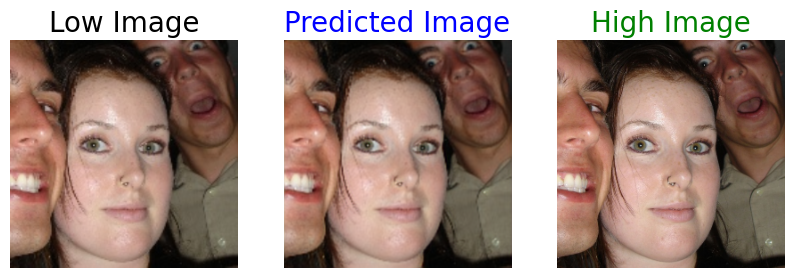

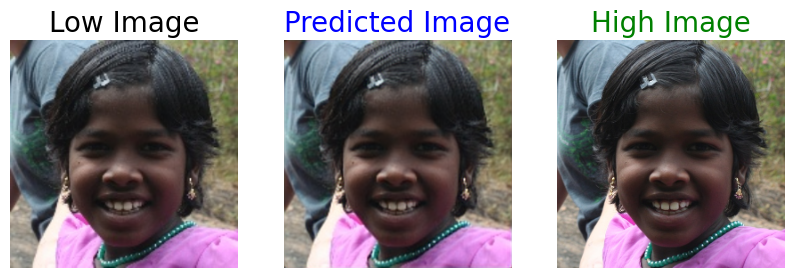

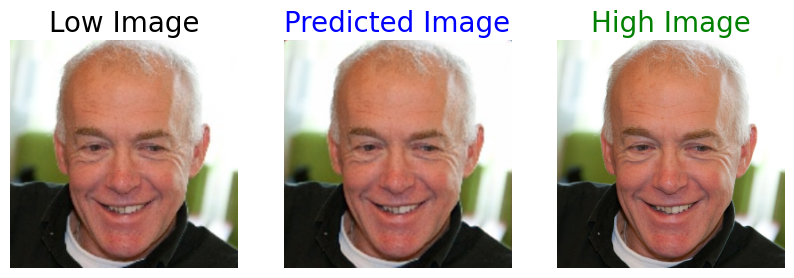

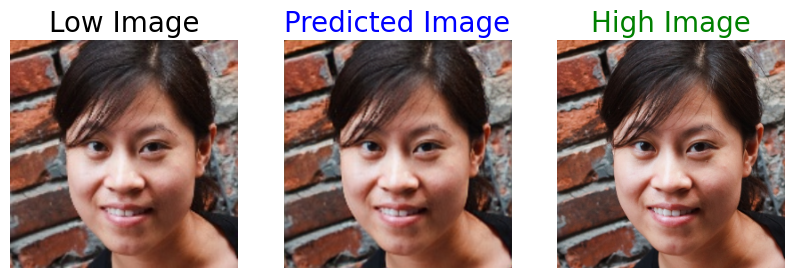

In [11]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the FSRCNN model
def FSRCNN(input_shape=(None, None, 3)):
    model = models.Sequential([
        layers.Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(3, (5, 5), padding='same')  # Output 3 channels for RGB image
    ])
    return model

# Instantiate the FSRCNN model
fsrcnn_model = FSRCNN()

# Compile the model
fsrcnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
fsrcnn_model.summary()

# Train the model
history = fsrcnn_model.fit(train_low_image, train_high_image,
                           validation_data=(validation_low_image, validation_high_image),
                           epochs=20, batch_size=32)

# Evaluate the model using PSNR
from skimage.metrics import peak_signal_noise_ratio

def calculate_psnr(original, compressed):
    return peak_signal_noise_ratio(original, compressed)

# Generate predicted high-resolution images for test data
predicted_images = fsrcnn_model.predict(test_low_image)

# Calculate PSNR for each predicted image
psnr_scores = []
for i in range(len(test_high_image)):
    psnr = calculate_psnr(test_high_image[i], predicted_images[i])
    psnr_scores.append(psnr)

# Calculate average PSNR across all test images
average_psnr = sum(psnr_scores) / len(psnr_scores)
print("Average PSNR:", average_psnr)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, None, None, 64) │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, None, None, 32) │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, None, None, 32) │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, None, None, 3)  │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,587 (467.14 KB)

 Trainable params: 119,587 (467.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-03-24 19:47:02.884892: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[32,64,256,256]{3,2,1,0}), window={size=9x9 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-24 19:47:03.651171: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.766384734s
Trying algorithm eng0{} for conv (f32[64,3,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[32,64,256,256]{3,2,1,0}), window={size=9x9 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-24 19:47:05.933252: E external/loca

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.0440

2024-03-24 19:48:33.606229: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-24 19:48:34.837386: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.23127113s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-24 19:48:37.490801: E external/l

63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 0.0431 - val_loss: 0.0042
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 490ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 489ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - loss: 0.0011 - val_loss: 9.8049e-04
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/s

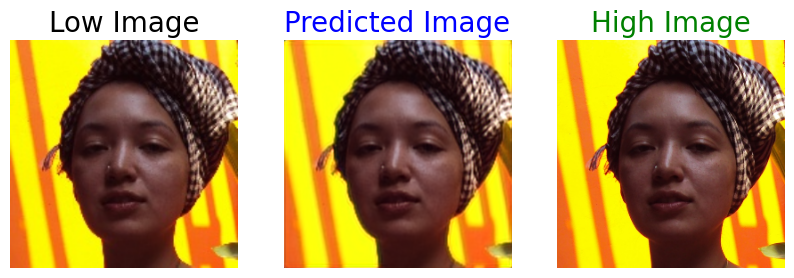

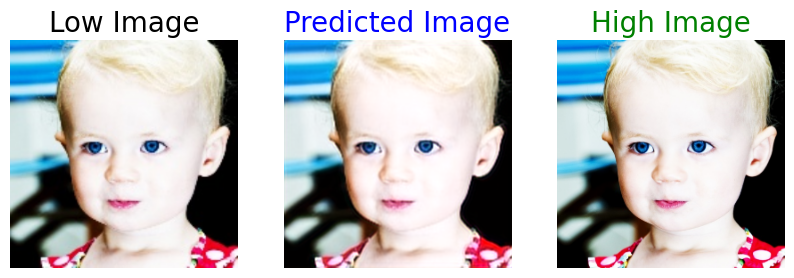

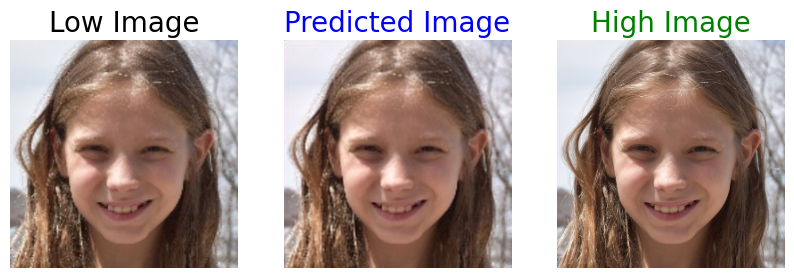

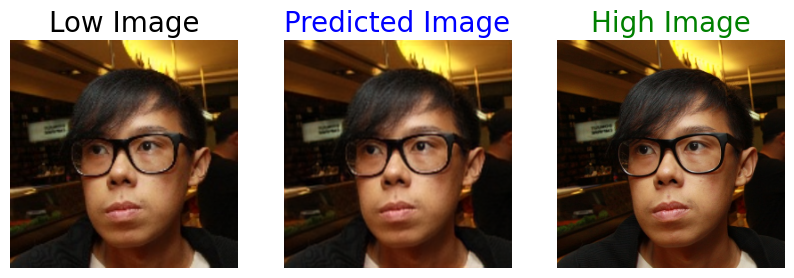

In [13]:
# Visualize some of the predicted images
num_samples = 4
random_indices = np.random.choice(len(predicted_images), num_samples, replace=False)

for index in random_indices:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Low Image', color='black', fontsize=20)
    plt.imshow(test_low_image[index])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', color='blue', fontsize=20)
    plt.imshow(predicted_images[index])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('High Image', color='green', fontsize=20)
    plt.imshow(test_high_image[index])
    plt.axis('off')
    plt.show()